 # **Import of modules & colors**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import json
import csv
import datetime as dt

import warnings

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

from numpy import mean
from numpy import std

from typing import List

In [2]:
import seaborn as sns
sns.set(style="ticks")
sns.set_color_codes("colorblind")
sns.set(style="darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

Color spectrum

In [4]:
color = [
'#000000',
'#000080',
'#0B0BFF',
'#98B5FF', 
'#BBC9DB',
'#797975',
'#0198E1',
'#00688B',
'#74CDDC', #nej
'#05EDFF',  
'#C9FFFF', 
'#8FBCBC',
'#457371',
'#28AE7B',
'#4DFFA5'
]

# **Load of data, new columns, datatypes and period of time definiton**

In [5]:
soubor = pd.read_csv('final.csv', encoding='utf-8', low_memory=False)

Datatypes

In [6]:
soubor['TIMETABLE_ARRIVAL_TIME'] = pd.to_datetime(soubor['TIMETABLE_ARRIVAL_TIME']).dt.time

In [7]:
soubor['ORIGIN_TIMESTAMP'] = pd.to_datetime(soubor['ORIGIN_TIMESTAMP']).dt.time

In [8]:
soubor['START_TIME'] = pd.to_datetime(soubor['START_TIME']).dt.time

New column with just the hour when the bus sent the location/was at the bus stop

In [9]:
for i, x in enumerate(soubor['ORIGIN_TIMESTAMP']):
    hour = x.hour
    soubor.loc[i,'HOUR'] = hour

Inside covid period / after covid period / week / weekend

In [10]:
inside_covid = soubor[(soubor['DATE'] <= '2020-05-17') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [11]:
len(inside_covid['UNICORN'].unique())

178

In [12]:
after_covid_week = soubor[(soubor['DATE'] >= '2020-05-18') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [13]:
len(after_covid_week['UNICORN'].unique())

168

In [14]:
after_covid_wknd = soubor[(soubor['DATE'] >= '2020-05-18') & (soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [15]:
len(after_covid_wknd['UNICORN'].unique())

26

In [16]:
after_covid_full = soubor[soubor['DATE'] >= '2020-05-18']

In [17]:
len(after_covid_full['UNICORN'].unique())

194

# **Data from the 'time of a day' point of view (6:50-10:30 am during workweek)**

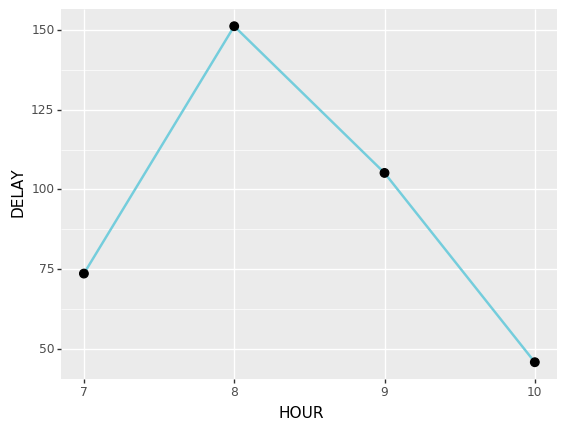

<ggplot: (-9223371882130959928)>

In [18]:
avg_delay_day = after_covid_week.groupby(['HOUR'])[['DELAY']].mean()
avg_delay_day = avg_delay_day.reset_index()

plot_delay_day = ggplot(avg_delay_day, aes(x='HOUR', y='DELAY')) + \
                    geom_line(color='#74CDDC',size=1) + \
                    geom_point(size=3) + \
                    scale_x_continuous(breaks=range(5, 13), minor_breaks=[]) + \
                    xlab("HOUR") + \
                    ylab("DELAY")
plot_delay_day

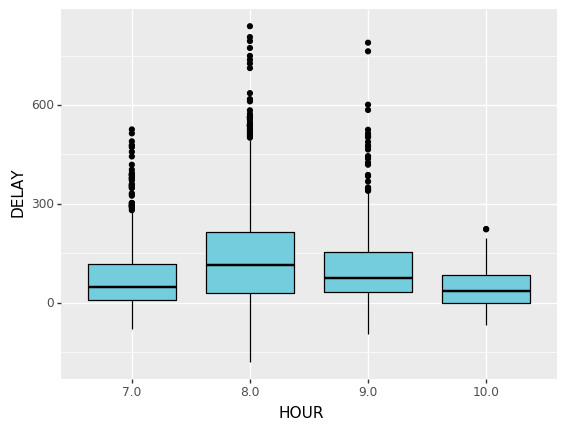

<ggplot: (-9223371882130963116)>

In [19]:
after_covid_week['HOUR_cat'] = after_covid_week['HOUR'].astype('category')

plotbox_delay_day = ggplot(after_covid_week, aes(x='HOUR_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("HOUR") + \
            ylab("DELAY")
plotbox_delay_day

In [20]:
after_covid_week.groupby('HOUR')['DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
HOUR,,,,,,,,
7.0,834.0,73.565947,97.926896,-79.0,10.00,48.0,116.75,526.0
8.0,847.0,151.197166,155.647743,-180.0,30.00,115.0,216.00,839.0
9.0,665.0,105.153383,113.303718,-93.0,34.00,75.0,154.00,789.0
10.0,174.0,45.747126,61.741250,-68.0,-0.75,36.5,85.75,224.0


### **Conclusion: peak of the highest delay is around 8 to 9 o'clock ->  new timeline**

In [21]:
t1 = dt.time(7,30,0)
t2 = dt.time(9,0,0)

In [22]:
peak_time = after_covid_week[ (after_covid_week['ORIGIN_TIMESTAMP']>=t1) & (after_covid_week['ORIGIN_TIMESTAMP']<=t2) ]

Statistical summary for new dataframe (workweek, 7:30 - 9:00 am) for Actual Delay column

In [23]:
peak_time['DELAY'].describe()

count    1323.000000
mean      129.776266
std       144.119093
min      -180.000000
25%        26.000000
50%        89.000000
75%       194.500000
max       839.000000
Name: DELAY, dtype: float64

# **Normality test**

source: *https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/*

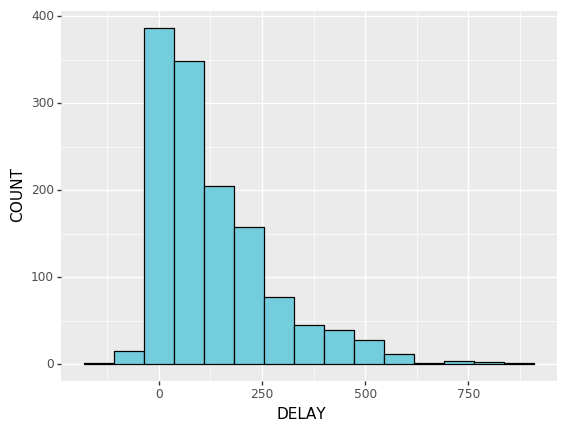

<ggplot: (-9223371882130338380)>

In [24]:
plot_hist1 = ggplot(peak_time, aes(x='DELAY')) + \
            geom_histogram(color='black', fill='#74CDDC', bins=15) + \
            xlab("DELAY") + \
            ylab("COUNT")

plot_hist1

In [25]:
stat, p = shapiro(peak_time['DIFF_DELAY'])
print(f'Statistics={stat}, p={round(p,5)}')

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.8532360792160034, p=0.0
Sample does not look Gaussian (reject H0)


### Conclusion: there is no normal distribution (to be sure :))

# **Charts visualize relationship between delay/delay diff and a bus stop**

Delay difference = increase/decrease of the delay from previous stop - we will be able to see between which stops the delay grew the most

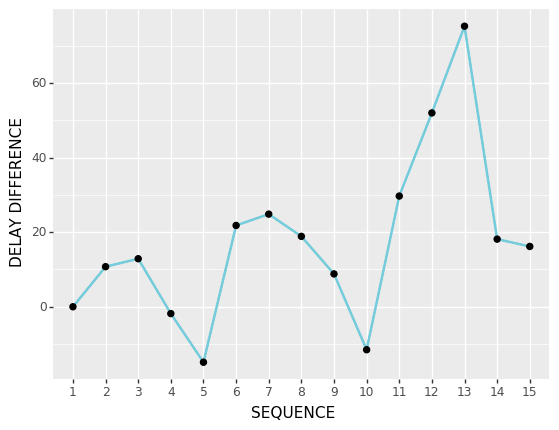

<ggplot: (-9223371882130392864)>

In [26]:
avg_delay_for_stop = peak_time.groupby(['SEQUENCE'])[['DIFF_DELAY']].mean()
avg_delay_for_stop = avg_delay_for_stop.reset_index()

plot_poin_delay_stop = ggplot(avg_delay_for_stop, aes(x='SEQUENCE', y='DIFF_DELAY')) + \
    geom_point() + \
    geom_line() + \
    geom_line(color='#74CDDC',size=1) + \
    geom_point(size=2) + \
    scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)) + \
    xlab("SEQUENCE") + \
    ylab("DELAY DIFFERENCE")
plot_poin_delay_stop

#### Previous delay vs. delay difference

Points represent rows in the dataframe - every row is a moment when the bus was at the bus stop and the location with additional information was sent

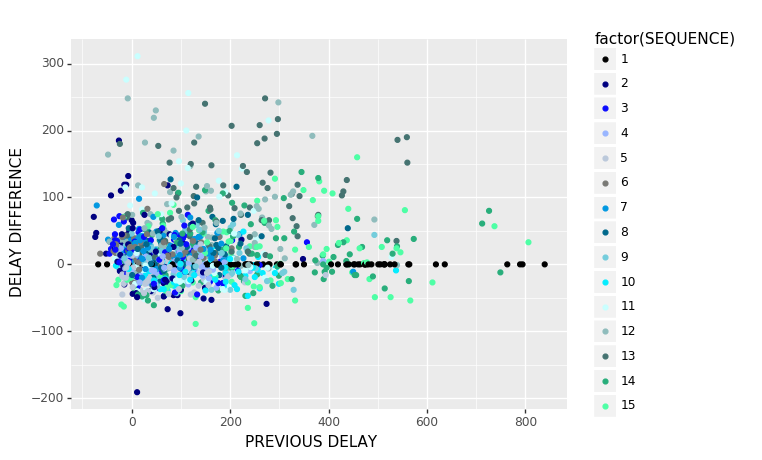

<ggplot: (-9223371882130442104)>

In [27]:
plot_point1 = ggplot(peak_time,(aes(x='PREV_DELAY', y='DIFF_DELAY',color = 'factor(SEQUENCE)'))) + \
        scale_color_manual(values=color) + \
        geom_point() + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point1

#### Better! Previous delay vs. delay difference for each bus stop


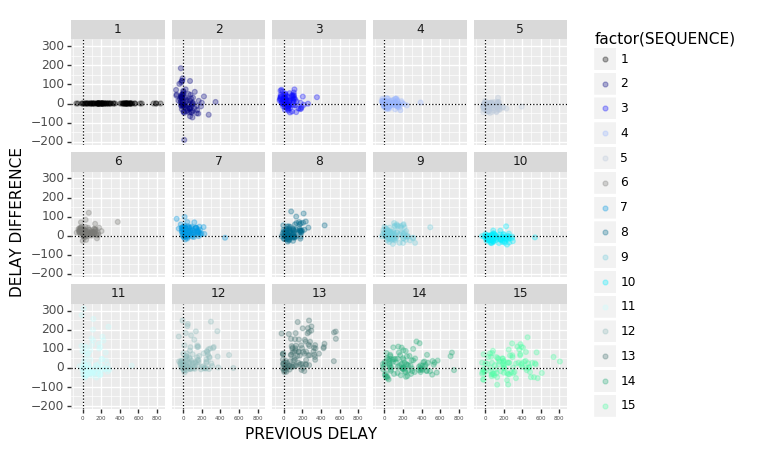

<ggplot: (-9223371882129198232)>

In [28]:
plot_point2 = ggplot(peak_time, aes(x='PREV_DELAY', y='DIFF_DELAY', color = 'factor(SEQUENCE)' )) + \
        geom_point(alpha=0.3) + \
        geom_hline(yintercept=0,linetype='dotted') + \
        geom_vline(xintercept=0,linetype='dotted') + \
        theme(axis_text_x = element_text(size=4)) + \
        facet_wrap(['SEQUENCE'], nrow=3) + \
        scale_color_manual(values=color) + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point2

### **Conclusion: At bus stop number 2 and from 11 further we can see spread from the 0**

#### Boxplot visualize the delay difference for each stop

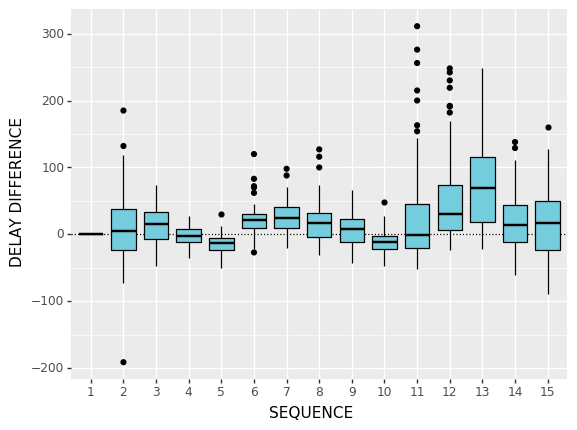

<ggplot: (-9223371891713694348)>

In [96]:
peak_time['SEQUENCE_cat'] = peak_time['SEQUENCE'].astype('category')

plot_box1 = ggplot(peak_time, aes(x='SEQUENCE_cat', y='DIFF_DELAY')) + \
            geom_hline(yintercept=0,linetype='dotted') + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE")
plot_box1

### **Kruskal-Wallis H-test**

source: *https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/*

In [97]:
def specify_seq(data: pd.DataFrame, num_seq: int):
    new_df = data[data['SEQUENCE']==num_seq]['DIFF_DELAY']
    return new_df

In [98]:
print(f'For sequence 2: mean={round(mean(specify_seq(peak_time,2)),4)}, std={round(std(specify_seq(peak_time,2)),4)}')
print(f'For sequence 3: mean={round(mean(specify_seq(peak_time,3)),4)}, std={round(std(specify_seq(peak_time,3)),4)}')
print(f'For sequence 4: mean={round(mean(specify_seq(peak_time,4)),4)}, std={round(std(specify_seq(peak_time,4)),4)}')
print(f'For sequence 5: mean={round(mean(specify_seq(peak_time,5)),4)}, std={round(std(specify_seq(peak_time,5)),4)}')
print(f'For sequence 6: mean={round(mean(specify_seq(peak_time,6)),4)}, std={round(std(specify_seq(peak_time,6)),4)}')
print(f'For sequence 7: mean={round(mean(specify_seq(peak_time,7)),4)}, std={round(std(specify_seq(peak_time,7)),4)}')
print(f'For sequence 8: mean={round(mean(specify_seq(peak_time,8)),4)}, std={round(std(specify_seq(peak_time,8)),4)}')
print(f'For sequence 9: mean={round(mean(specify_seq(peak_time,9)),4)}, std={round(std(specify_seq(peak_time,9)),4)}')
print(f'For sequence 10: mean={round(mean(specify_seq(peak_time,10)),4)}, std={round(std(specify_seq(peak_time,10)),4)}')
print(f'For sequence 11: mean={round(mean(specify_seq(peak_time,11)),4)}, std={round(std(specify_seq(peak_time,11)),4)}')
print(f'For sequence 12: mean={round(mean(specify_seq(peak_time,12)),4)}, std={round(std(specify_seq(peak_time,12)),4)}')
print(f'For sequence 13: mean={round(mean(specify_seq(peak_time,13)),4)}, std={round(std(specify_seq(peak_time,13)),4)}')
print(f'For sequence 14: mean={round(mean(specify_seq(peak_time,14)),4)}, std={round(std(specify_seq(peak_time,14)),4)}')
print(f'For sequence 15: mean={round(mean(specify_seq(peak_time,15)),4)}, std={round(std(specify_seq(peak_time,15)),4)}')

For sequence 2: mean=10.75, std=53.5852
For sequence 3: mean=12.8795, std=28.102
For sequence 4: mean=-1.8293, std=13.9789
For sequence 5: mean=-14.8642, std=15.8003
For sequence 6: mean=21.8025, std=21.6558
For sequence 7: mean=24.8444, std=21.5803
For sequence 8: mean=18.881, std=31.0489
For sequence 9: mean=8.8118, std=25.4195
For sequence 10: mean=-11.5176, std=16.1323
For sequence 11: mean=29.6854, std=75.5834
For sequence 12: mean=51.9688, std=61.5796
For sequence 13: mean=75.2222, std=66.8175
For sequence 14: mean=18.1373, std=42.0537
For sequence 15: mean=16.1771, std=50.2658


To determine whether more than two independent samples have a different distribution

In [99]:
stat, p = kruskal(specify_seq(bebe,2),specify_seq(bebe,3),specify_seq(bebe,4),specify_seq(bebe,5),
                  specify_seq(bebe,6),specify_seq(bebe,7),specify_seq(bebe,8),specify_seq(bebe,9),
                  specify_seq(bebe,10),specify_seq(bebe,11),specify_seq(bebe,12),specify_seq(bebe,13),
                  specify_seq(bebe,14),specify_seq(bebe,15))
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=296.5991689214198, p=1.2378172130399555e-55
Different distributions (reject H0)


### **Conclusion: bus stops have different data distribution**

# **Charts visualize relationship between delay and day of week**

Dataframe in period after covid, whole week with weekend, 7:30 - 9 am

In [29]:
full_week = after_covid_full[ (after_covid_full['ORIGIN_TIMESTAMP']>=t1) & (after_covid_full['ORIGIN_TIMESTAMP']<=t2) ]

In [30]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
full_week['DAY_OF_WEEK'] = pd.Categorical(full_week['DAY_OF_WEEK'], days)
full_week.sort_values('DAY_OF_WEEK')

,TRIP_ID,ROUTE,DAY_OF_WEEK,DATE,UNICORN,START_TIME,HEADSIGN,STOP_ID,STOP_SEQUENCE,STOP_NAME,SHAPE_DIST_TRAVELED,DELAY,ORIGIN_TIMESTAMP,TIMETABLE_ARRIVAL_TIME,DIFF_DELAY,PREV_DELAY,SEQUENCE,HOUR
4147,333_1052_200302,333,Monday,2020-05-25,333_1052_200302_25_May,07:54:00,"Praha,Kačerov",U335Z2,19,Libuš,13.97672,216.0,08:26:40,08:23:00,24.0,192.0,8,8.0
4508,333_1052_200302,333,Monday,2020-05-18,333_1052_200302_18_May,07:54:00,"Praha,Kačerov",U804Z2,20,U Zvoničky,14.28738,86.0,08:25:09,08:24:00,-16.0,102.0,9,8.0
4509,333_1052_200302,333,Monday,2020-05-18,333_1052_200302_18_May,07:54:00,"Praha,Kačerov",U194Z2,21,Jalodvorská,14.64625,59.0,08:25:51,08:25:00,-27.0,86.0,10,8.0
4510,333_1052_200302,333,Monday,2020-05-18,333_1052_200302_18_May,07:54:00,"Praha,Kačerov",U749Z2,22,Tempo,15.51512,74.0,08:28:12,08:27:00,15.0,59.0,11,8.0
4511,333_1052_200302,333,Monday,2020-05-18,333_1052_200302_18_May,07:54:00,"Praha,Kačerov",U656Z2,23,Sídliště Krč,15.85395,68.0,08:29:14,08:28:00,-6.0,74.0,12,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6527,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U545Z2,16,Písnice,12.76669,23.0,08:06:28,08:06:00,-2.0,25.0,3,8.0
6528,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U546Z2,17,Ke Březině,13.14639,15.0,08:07:08,08:07:00,-8.0,23.0,4,8.0
6529,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U871Z2,18,Lipovická,13.34632,-10.0,08:07:36,08:08:00,-25.0,15.0,5,8.0
6519,333_651_200307,333,Sunday,2020-05-24,333_651_200307_24_May,07:30:00,"Praha,Kačerov",U194Z2,10,Jalodvorská,5.97226,28.0,07:43:16,07:43:00,1.0,27.0,10,7.0


#### Boxplot visualize the delay for each day

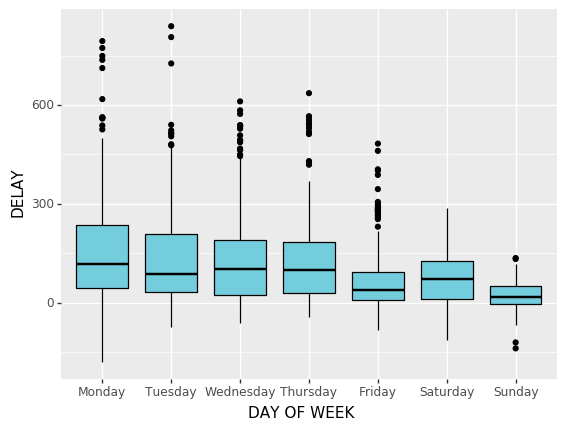

<ggplot: (-9223371891711603648)>

In [102]:
full_week['DAY_OF_WEEK_cat'] = full_week['DAY_OF_WEEK'].astype('category')

plot_box2 = ggplot(full_week, aes(x='DAY_OF_WEEK_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("DAY OF WEEK") + \
            ylab("DELAY")
plot_box2

In [103]:
days_col = ['#74CDDC' , '#ffffb3','#BBC9DB','#fb8072','#386cb0','#28AE7B','#4DFFA5']

####  Groupby of delay and its behaviour during the days for bus stops

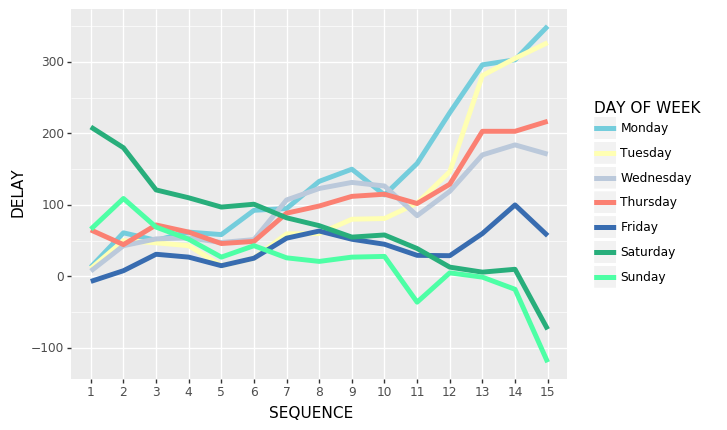

<ggplot: (-9223371891711552496)>


In [104]:
avg_delay_per_day_stop = full_week.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DELAY']].median()
avg_delay_per_day_stop = avg_delay_per_day_stop.reset_index()
plot_week1 = ggplot(avg_delay_per_day_stop, aes(x='SEQUENCE', y='DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY") + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
print(plot_week1)

### **Mann-Whitney U-test**

source: *https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/*

Saturday & Sunday

In [112]:
# generate two independent samples
dataSat = full_week[full_week['DAY_OF_WEEK']=='Saturday']['DELAY']
dataSun = full_week[full_week['DAY_OF_WEEK']=='Sunday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataSun, dataSat)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=570.0, p=0.00011316291843161926
Different distribution (reject H0)


Friday & Saturday

In [113]:
# generate two independent samples
dataSat = full_week[full_week['DAY_OF_WEEK']=='Saturday']['DELAY']
dataFri = full_week[full_week['DAY_OF_WEEK']=='Friday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataFri, dataSat)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=4237.0, p=0.06412811456255114
Same distribution (fail to reject H0)


Monday & Wednesday + rest of the days was tested in pair too

In [117]:
# generate two independent samples
dataMon = full_week[full_week['DAY_OF_WEEK']=='Tuesday']['DELAY']
dataWed = full_week[full_week['DAY_OF_WEEK']=='Thursday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataMon, dataWed)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=35458.0, p=0.27190758451834074
Same distribution (fail to reject H0)


### **Conclusion: same data distribution has**

Vizualization of the conclusion - data distribution of the delay for each day

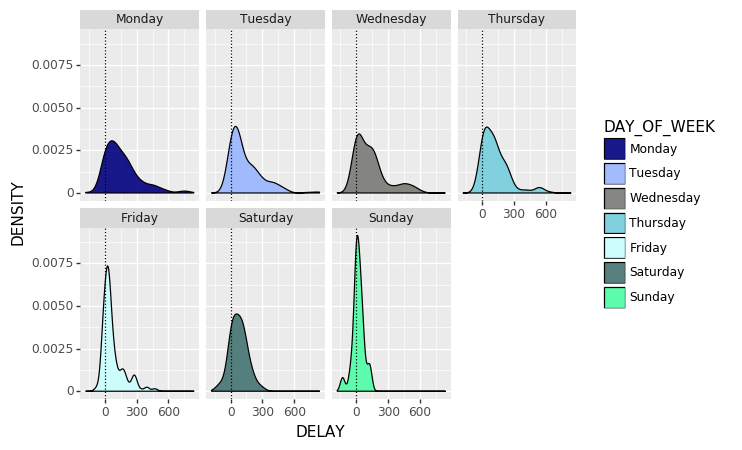

<ggplot: (-9223371882128766200)>

In [31]:
plot_hist3 = ggplot(full_week, aes(x='DELAY', fill='DAY_OF_WEEK')) + \
            geom_density(alpha=.9, color='black') + \
            facet_wrap(['DAY_OF_WEEK'], nrow=2) + \
            geom_vline(xintercept=0,linetype='dotted') + \
            scale_fill_manual(values=['#000080','#98B5FF','#797975','#74CDDC','#C9FFFF','#457371','#4DFFA5']) + \
            xlab("DELAY") + \
            ylab("DENSITY")
plot_hist3

# **Graf porovnání zpožděných a nezpožděných autobusů během pracovního týdne během zkoumaného čas. období (7:30-9)**

In [97]:
delay_2minutes = bebe[ (bebe['DELAY']>=120) & (bebe['DELAY']<300) ]
delay_5minutes = bebe[bebe['DELAY']>=300]
delay_nope = bebe[bebe['DELAY']<120]

In [98]:
delay_2 = delay_2minutes.groupby('DAY_OF_WEEK')['DELAY'].count()
delay_5 = delay_5minutes.groupby('DAY_OF_WEEK')['DELAY'].count()
at_time = delay_nope.groupby('DAY_OF_WEEK')['DELAY'].count()

In [99]:
index = ['Monday', 'Tuesday', 'Wednesday',
         'Thursday', 'Friday']
df_barplot = pd.DataFrame({
    'AT TIME': at_time,
    '2-5 MIN': delay_2,
    'MORE THAN 5 MIN':delay_5
}, index=index) 

In [105]:
m = pd.melt(df_barplot.reset_index(), id_vars=['index'])

In [106]:
m

,index,variable,value
0,Monday,AT TIME,118
1,Tuesday,AT TIME,138
2,Wednesday,AT TIME,122
3,Thursday,AT TIME,71
4,Friday,AT TIME,86
5,Monday,2-5 MIN,80
6,Tuesday,2-5 MIN,61
7,Wednesday,2-5 MIN,70
8,Thursday,2-5 MIN,42
9,Friday,2-5 MIN,22


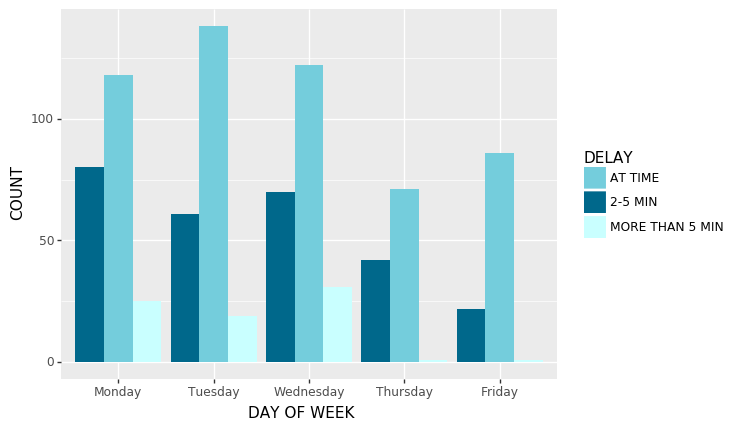

<ggplot: (-9223371921863316968)>

In [120]:
barplot = ggplot(m, aes(x = "index", y="value")) + \
                    xlab("DAY OF WEEK") + \
                    ylab("COUNT") + \
                    geom_bar(aes(fill = "variable"),stat = "identity", position = "dodge") + \
                    scale_fill_manual(values=['#00688B','#74CDDC', '#C9FFFF'],breaks=("AT TIME","2-5 MIN","MORE THAN 5 MIN")) + \
                    labs(fill = "DELAY") + \
                    scale_x_discrete(limits=index)
barplot